## Imports

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
# comment

## Download Data

In [14]:
MONTHS = 12*10

# Define weights (original fund tickers)
weights = {
    "AUTO.OL": 0.019094, "BKW.SW": 0.050846, "BMI": 0.033615, "CGNX": 0.028368, "CLH": 0.038201,
    "CWST": 0.047824, "CWY.AX": 0.038031, "ECL": 0.054767, "ENEL.MI": 0.063910, "ENR.DE": 0.023263,
    "FSLR": 0.019741, "GF.SW": 0.035485, "GFL": 0.038149, "GXO": 0.028886, "IBE.MC": 0.066922,
    "KGX.DE": 0.029591, "MANH": 0.032971, "NEE": 0.040971, "ORSTED.CO": 0.028671, "SYM": 0.011842,
    "TOM.OL": 0.019474, "VIE.PA": 0.055726, "VLTO": 0.053097, "WM": 0.057568, "XYL": 0.048435, "ZBRA": 0.034552
}

weights = pd.Series(weights)

# Define time range
end_date = pd.Timestamp("2025-04-01") # For consistency
start_date = end_date - pd.DateOffset(months=MONTHS)

# Benchmark tickers
benchmark_tickers = ["^GSPC", "^SSMI", "^DJI"]
basket_tickers = list(weights.index)
all_tickers = basket_tickers + benchmark_tickers

# Download data
print(f"Downloading {MONTHS} months of data...")
data = yf.download(all_tickers, start=start_date, end=end_date, auto_adjust=True, progress=False)


## Clean Up Data

- We are (currently) only interested in close
- Deal with yfinance api...
- Linear interpolation between missing values
- Drop sparse data

In [15]:
# Handle multi-index if present (yfinance...)

if isinstance(data.columns, pd.MultiIndex):
    if 'Close' in data.columns.levels[0]:
        data = data['Close']
    elif 'Adj Close' in data.columns.levels[0]:
        data = data['Adj Close']
    else:
        try:
            data.columns = data.columns.droplevel(0)
        except:
            price_cols = [col for col in data.columns if col[0] in ['Close', 'Adj Close']]
            if price_cols:
                data = data[price_cols]
                data.columns = data.columns.droplevel(0)
            else:
                data.columns = ['_'.join(col).strip() for col in data.columns.values]

# Flatten remaining multi-index if needed
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(0)
elif any(isinstance(col, tuple) for col in data.columns):
    data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]

# Interpolate and drop sparsely populated rows/columns
print("Interpolating and cleaning data...")
data = data.interpolate(method="linear")
data = data.dropna(axis=0, thresh=int(0.7 * len(data.columns)))
data = data.dropna(axis=1, thresh=int(0.7 * len(data)))

# Keep only tickers with valid data
benchmark_tickers = [t for t in benchmark_tickers if t in data.columns]
valid_tickers = data.columns.drop(benchmark_tickers, errors='ignore')
valid_weights = weights[weights.index.isin(valid_tickers)]

if valid_weights.empty:
    raise ValueError("No valid tickers found after cleaning.")

# Re-normalize weights after cleaning
valid_weights = valid_weights / valid_weights.sum()

print("Final tickers:", list(valid_weights.index))
print("Final benchmark tickers:", benchmark_tickers)
print("Data cleaned and ready.")


Interpolating and cleaning data...
Final tickers: ['BKW.SW', 'BMI', 'CGNX', 'CLH', 'CWST', 'CWY.AX', 'ECL', 'ENEL.MI', 'FSLR', 'GF.SW', 'IBE.MC', 'KGX.DE', 'MANH', 'NEE', 'ORSTED.CO', 'TOM.OL', 'VIE.PA', 'WM', 'XYL', 'ZBRA']
Final benchmark tickers: ['^GSPC', '^SSMI', '^DJI']
Data cleaned and ready.


## Normalize Basket

In [16]:
# Normalize Basket (Fund) to 100 at the start of the period
normalized_basket = data[valid_weights.index].divide(data[valid_weights.index].iloc[0]) * 100
basket_index = normalized_basket.multiply(valid_weights, axis=1).sum(axis=1)

# Normalize Benchmarks (S&P 500, SMI, DJ) to 100 at the start of the period
normalized_benchmarks = {}
for ticker in benchmark_tickers:
    if ticker in data:
        normalized_benchmarks[ticker] = data[ticker] / data[ticker].iloc[0] * 100
        print(f"Benchmark {ticker} normalized.")
    else:
        print(f"Benchmark ticker {ticker} not found in data after cleaning.")
# Normalize Basket (Fund) to 100 at the start of the period
normalized_basket = data[valid_weights.index].divide(data[valid_weights.index].iloc[0]) * 100
basket_index = normalized_basket.multiply(valid_weights, axis=1).sum(axis=1)

# Normalize Benchmarks (S&P 500, SMI, DJ) to 100 at the start of the period
normalized_benchmarks = {}
for ticker in benchmark_tickers:
    if ticker in data:
        normalized_benchmarks[ticker] = data[ticker] / data[ticker].iloc[0] * 100
        print(f"Benchmark {ticker} normalized.")
    else:
        print(f"Benchmark ticker {ticker} not found in data after cleaning.")


Benchmark ^GSPC normalized.
Benchmark ^SSMI normalized.
Benchmark ^DJI normalized.
Benchmark ^GSPC normalized.
Benchmark ^SSMI normalized.
Benchmark ^DJI normalized.


## Plots

### Basket vs Benchmarks

We look at normalized returns and compare our basket to the benchmarks (S&P500, Dow Jones, SMI).

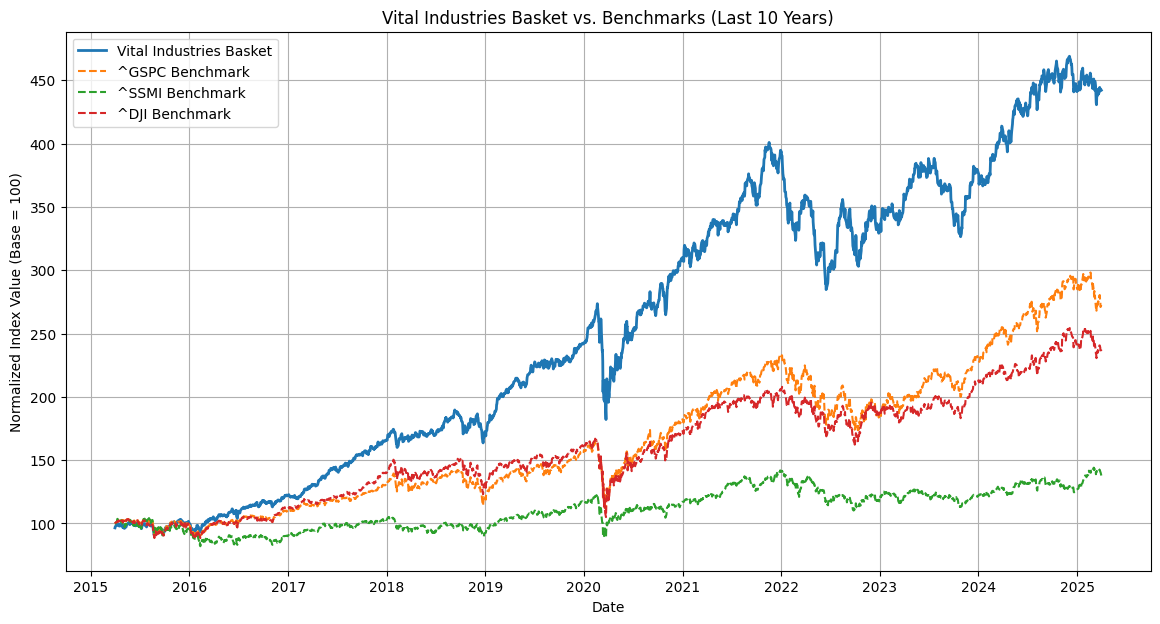

In [17]:
# Plotting the basket index and benchmarks
plt.figure(figsize=(14, 7))
plt.plot(basket_index, label='Vital Industries Basket', linewidth=2)

# Plot each benchmark
for ticker, normalized_benchmark in normalized_benchmarks.items():
    plt.plot(normalized_benchmark, label=f'{ticker} Benchmark', linestyle='--')

# Labels, title, and legend
plt.title(f'Vital Industries Basket vs. Benchmarks (Last {int(MONTHS/12)} Years)')
plt.xlabel('Date')
plt.ylabel('Normalized Index Value (Base = 100)')
plt.legend()
plt.grid(True)
plt.show()


### Correlation: Basket vs Benchmarks

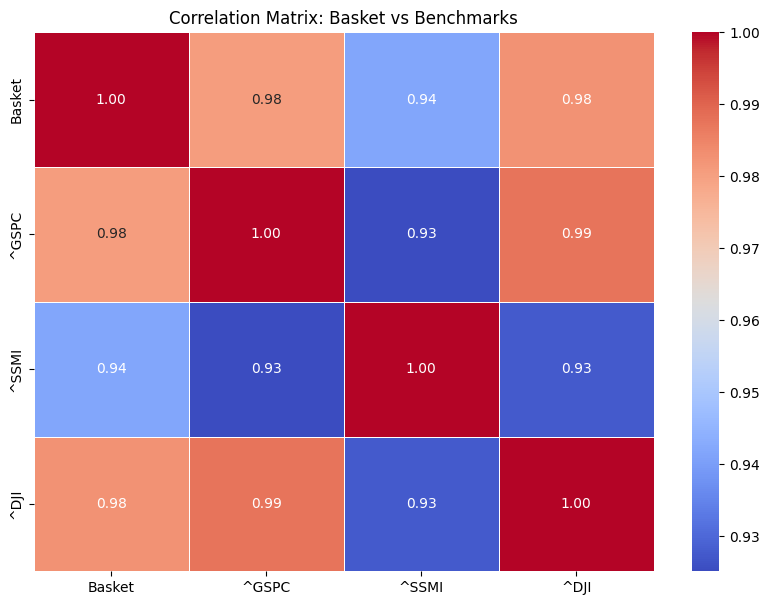

In [18]:
# Combine all data (basket + benchmarks) for correlation analysis
combined_data = pd.concat([basket_index] + list(normalized_benchmarks.values()), axis=1)
combined_data.columns = ['Basket'] + [ticker for ticker in benchmark_tickers]

# Calculate the correlation matrix
correlation_matrix = combined_data.corr()

# Plotting correlation matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)
plt.title('Correlation Matrix: Basket vs Benchmarks')
plt.show()


### Regression Metrics: Alpha, Beta, and R-squared

**TLDR Explanation:**

* **Alpha:**  Measures the basket's excess return compared to the benchmark.
    * Positive Alpha: Basket outperformed the benchmark (risk-adjusted).
    * Negative Alpha: Basket underperformed the benchmark (risk-adjusted).
    * Alpha of 0: Basket performed as expected given the benchmark.

* **Beta:**  Measures the basket's volatility relative to the benchmark.
    * Beta = 1: Basket's price tends to move in the same direction and magnitude as the benchmark.
    * Beta > 1: Basket is more volatile than the benchmark.
    * Beta < 1: Basket is less volatile than the benchmark.

* **R-squared:** Measures how well the benchmark explains the basket's movements.
    * R-squared close to 1:  Benchmark explains most of the basket's price variations.
    * R-squared close to 0: Benchmark explains very little of the basket's price variations.

^GSPC: Alpha=0.0784, Beta=0.7334, R²=0.6414
^SSMI: Alpha=0.1321, Beta=0.7011, R²=0.3973
^DJI: Alpha=0.0881, Beta=0.7395, R²=0.6258


/tmp/ipykernel_709957/52038788.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  daily_alpha = model.params[0]
/tmp/ipykernel_709957/52038788.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
/tmp/ipykernel_709957/52038788.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  daily_alpha = model.params[0]
/tmp/ipykernel_709957/52038788.py:7: FutureWarning: Series.__getitem__ treating keys as positions is dep

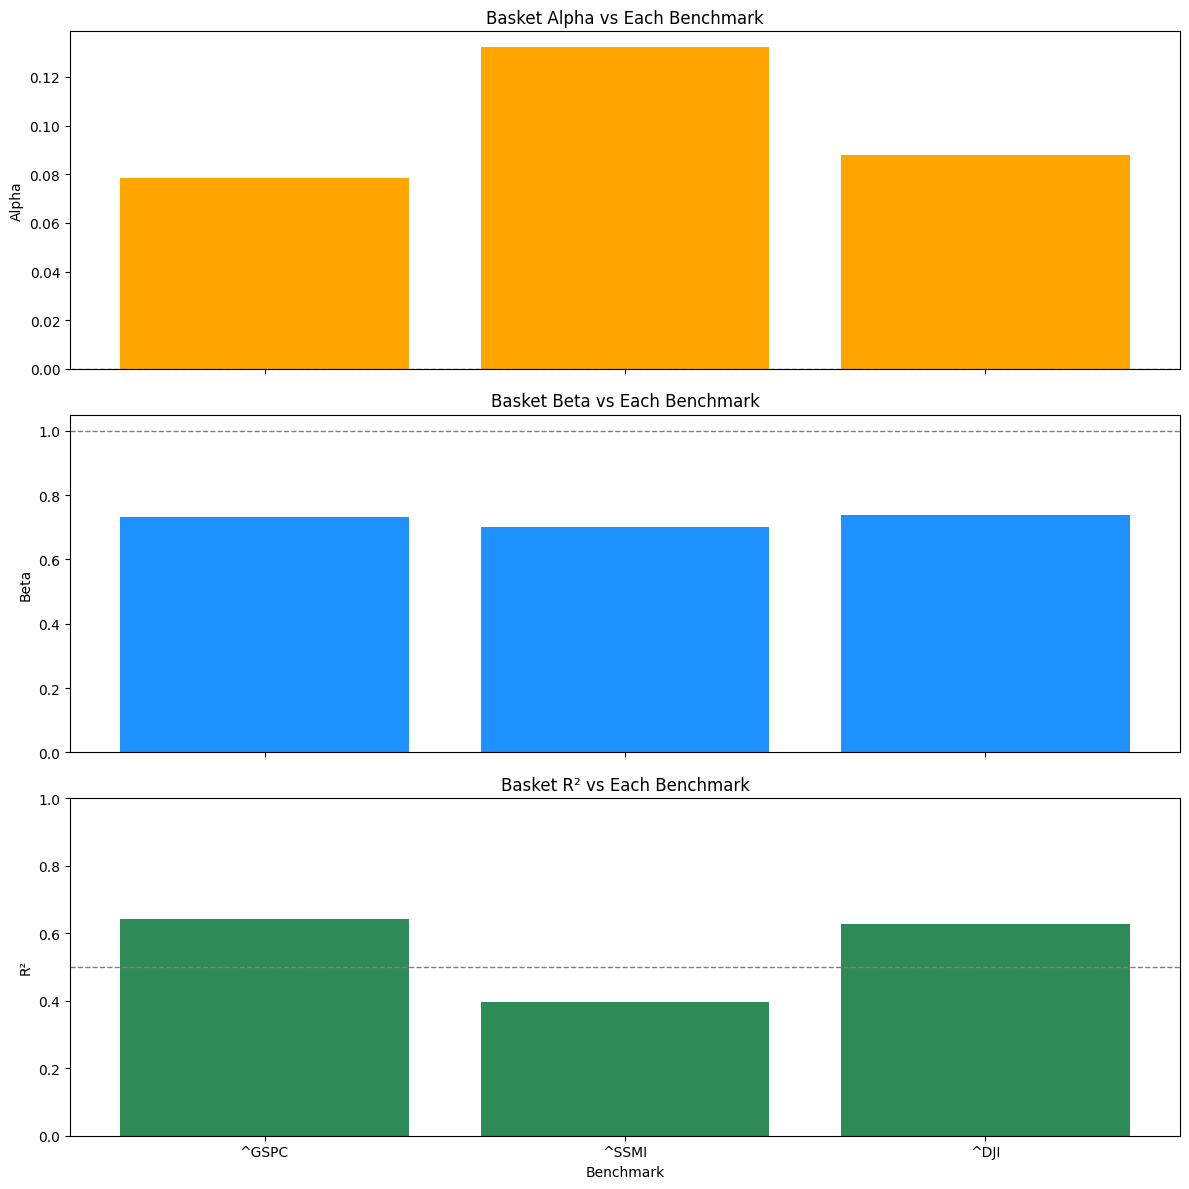

In [19]:
def compute_regression_metrics(basket_returns, benchmark_returns, periods=252):
    benchmark_returns = sm.add_constant(benchmark_returns)
    model = sm.OLS(basket_returns, benchmark_returns).fit()
    daily_alpha = model.params[0]
    # Annualize alpha (similar to annualizing returns)
    alpha = daily_alpha * periods
    beta = model.params[1]
    r_squared = model.rsquared
    return alpha, beta, r_squared

# Dictionaries to store results
alpha_values = {}
beta_values = {}
r_squared_values = {}

# Loop over each benchmark
for benchmark_name, normalized_benchmark in normalized_benchmarks.items():
    basket_returns = basket_index.pct_change().dropna()
    benchmark_prices_raw = data[benchmark_name]
    benchmark_returns = benchmark_prices_raw.pct_change().dropna()

    # Align the data by date
    combined = pd.concat([basket_returns, benchmark_returns], axis=1).dropna()
    aligned_basket = combined.iloc[:, 0]
    aligned_benchmark = combined.iloc[:, 1]

    # Compute alpha, beta, and R²
    alpha, beta, r_squared = compute_regression_metrics(aligned_basket, aligned_benchmark) 

    # Store the results
    alpha_values[benchmark_name] = alpha
    beta_values[benchmark_name] = beta
    r_squared_values[benchmark_name] = r_squared

    print(f"{benchmark_name}: Alpha={alpha:.4f}, Beta={beta:.4f}, R²={r_squared:.4f}")

# --- Plotting ---
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Alpha Plot
axes[0].bar(alpha_values.keys(), alpha_values.values(), color='orange')
axes[0].set_ylabel('Alpha')
axes[0].set_title('Basket Alpha vs Each Benchmark')
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)

# Beta Plot
axes[1].bar(beta_values.keys(), beta_values.values(), color='dodgerblue')
axes[1].set_ylabel('Beta')
axes[1].set_title('Basket Beta vs Each Benchmark')
axes[1].axhline(1, color='gray', linestyle='--', linewidth=1)

# R² Plot
axes[2].bar(r_squared_values.keys(), r_squared_values.values(), color='seagreen')
axes[2].set_ylabel('R²')
axes[2].set_title('Basket R² vs Each Benchmark')
axes[2].set_ylim(0, 1)
axes[2].axhline(0.5, color='gray', linestyle='--', linewidth=1)

# Final touches
plt.xlabel('Benchmark')
plt.tight_layout()
plt.show()

### Sharpe Ratio Analysis

**Explanation:**

The Sharpe Ratio is a measure of risk-adjusted return. It indicates how much excess return an investor receives for taking on additional risk.  A higher Sharpe Ratio is better, indicating more return for the same amount of risk.

**Calculation:**

Sharpe Ratio is calculated as:

**(Average Portfolio Return - Risk-Free Rate) / Standard Deviation of Portfolio Returns**

In this context, we assume a risk-free rate of 0 for simplicity.  We calculate the Sharpe Ratio for our "Vital Industries Basket" and compare it to the Sharpe Ratios of the benchmark indices to understand how our basket's risk-adjusted return compares to the broader market.

**Interpretation:**

* **Higher Sharpe Ratio:** Indicates better risk-adjusted performance. The portfolio is generating more return per unit of risk taken.
* **Lower Sharpe Ratio:** Indicates worse risk-adjusted performance. The portfolio is generating less return per unit of risk taken.
* **Comparison:** By comparing the Sharpe Ratio of the basket to the benchmarks, we can assess whether the basket provides a superior risk-adjusted return compared to simply investing in the market benchmarks.

/tmp/ipykernel_709957/2064767315.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df['Sharpe Ratio'], palette='Blues')


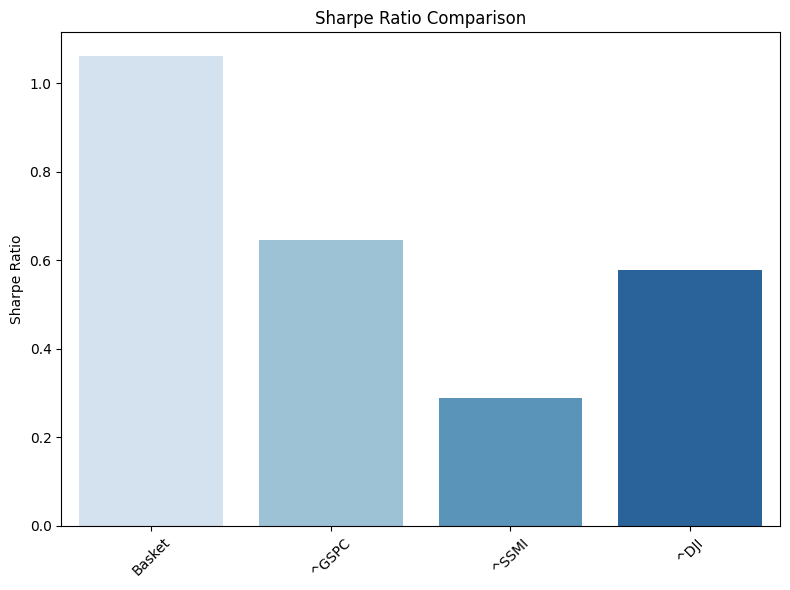

In [20]:
# Define a function to calculate the annualized Sharpe Ratio
def sharpe_ratio(returns, risk_free_rate=0, periods=252):
    excess_returns = returns - risk_free_rate
    # Annualize the ratio
    return np.mean(excess_returns) * periods / (np.std(excess_returns) * np.sqrt(periods))


# --- Corrected Basket Sharpe Ratio Calculation ---
# Calculate basket returns from the RAW prices of its constituents
basket_prices_raw = data[valid_weights.index] # Get raw prices for basket constituents
basket_daily_returns_raw = basket_prices_raw.pct_change().dropna() # Daily returns for each constituent
basket_portfolio_returns_raw = (basket_daily_returns_raw * valid_weights).sum(axis=1) # Portfolio returns
basket_sharpe = sharpe_ratio(basket_portfolio_returns_raw) # Sharpe Ratio from RAW portfolio returns

# Calculate basket Sharpe Ratio (annualized)
basket_sharpe = sharpe_ratio(basket_portfolio_returns_raw)

# Calculate benchmark Sharpe Ratios (annualized)
benchmark_sharpe = {}
for ticker in benchmark_tickers:
    benchmark_prices_raw = data[ticker]
    benchmark_returns = benchmark_prices_raw.pct_change().dropna()
    benchmark_sharpe[ticker] = sharpe_ratio(benchmark_returns)


# Calculate benchmark Sharpe Ratios (Correct - No Change Needed)
benchmark_sharpe = {}
for ticker in benchmark_tickers:
    benchmark_prices_raw = data[ticker]
    benchmark_returns = benchmark_prices_raw.pct_change().dropna()
    benchmark_sharpe[ticker] = sharpe_ratio(benchmark_returns)


metrics = {
    'Sharpe Ratio': [basket_sharpe] + list(benchmark_sharpe.values()),
}

# Convert to DataFrame for easier viewing
metrics_df = pd.DataFrame(metrics, index=['Basket'] + benchmark_tickers)

plt.figure(figsize=(8, 6))
sns.barplot(x=metrics_df.index, y=metrics_df['Sharpe Ratio'], palette='Blues')
plt.title('Sharpe Ratio Comparison')
plt.ylabel('Sharpe Ratio')
plt.xlabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Combo

/tmp/ipykernel_709957/2310251556.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sharpe_data.index, y='Sharpe Ratio', data=sharpe_data, palette=['green'] + ['steelblue']*len(benchmark_tickers), ax=ax4)


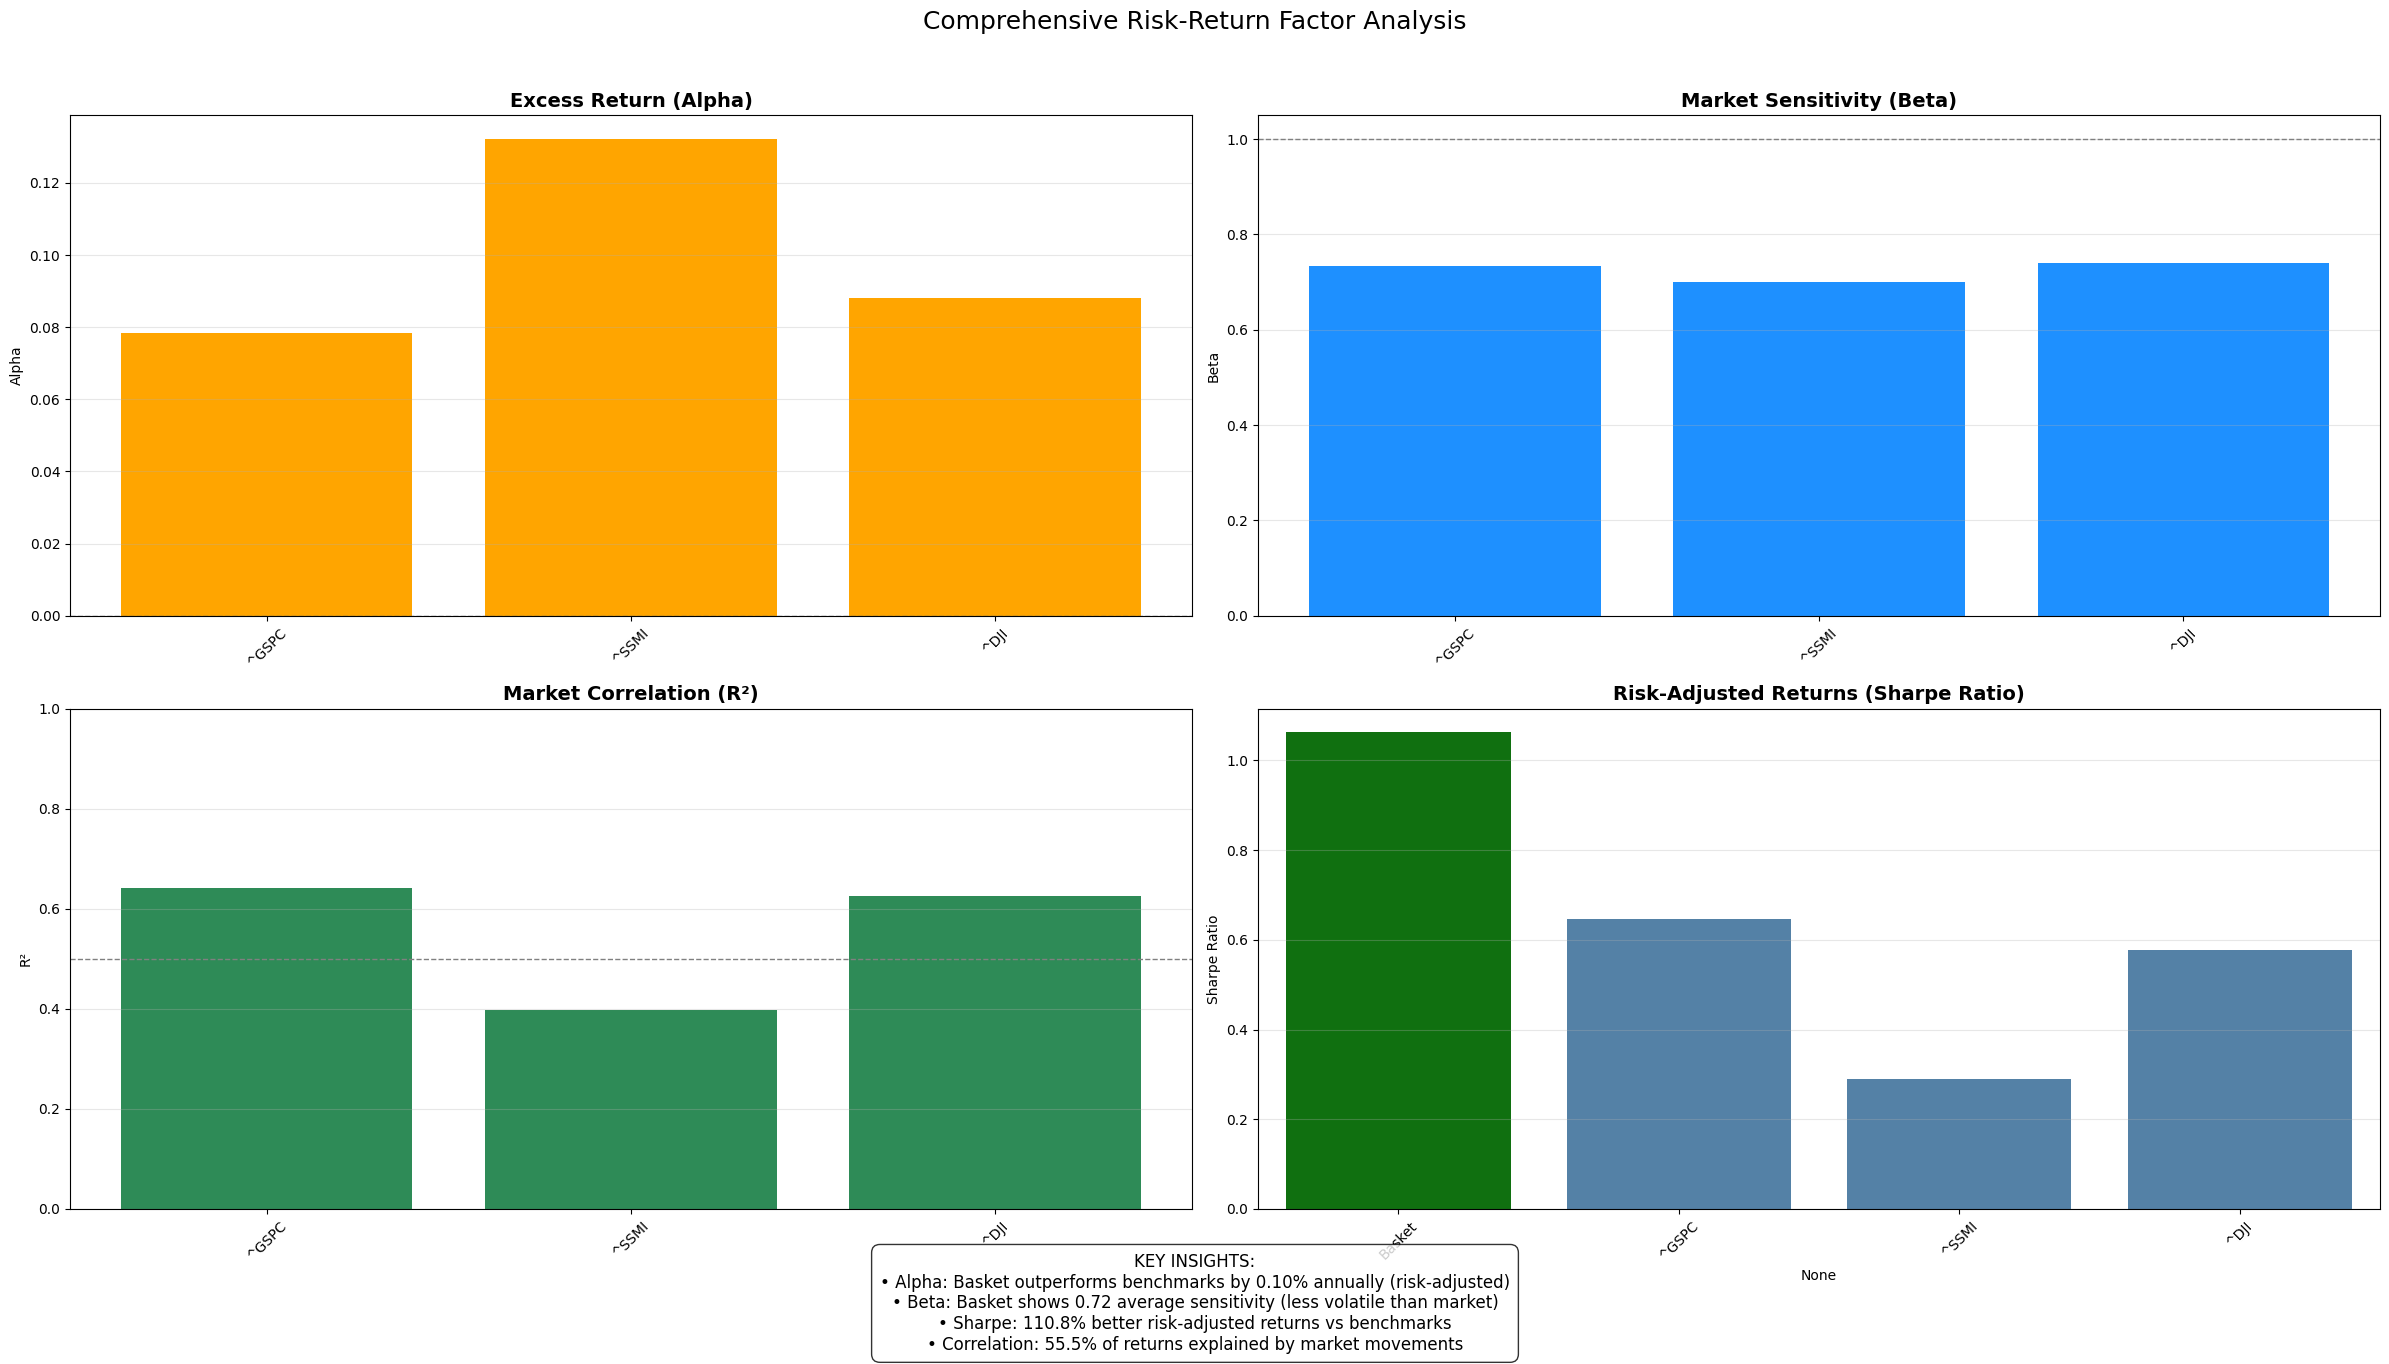

In [21]:
# Risk-Return Factor Analysis - Comprehensive 2x2 visualization
fig = plt.figure(figsize=(24, 14))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

# 1. Alpha Plot (Top Left)
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(alpha_values.keys(), alpha_values.values(), color='orange')
ax1.set_ylabel('Alpha')
ax1.set_title('Excess Return (Alpha)', fontsize=14, fontweight='bold')
ax1.axhline(0, color='gray', linestyle='--', linewidth=1)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# 2. Beta Plot (Top Right)
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(beta_values.keys(), beta_values.values(), color='dodgerblue')
ax2.set_ylabel('Beta')
ax2.set_title('Market Sensitivity (Beta)', fontsize=14, fontweight='bold')
ax2.axhline(1, color='gray', linestyle='--', linewidth=1)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# 3. R-squared Plot (Bottom Left)
ax3 = fig.add_subplot(gs[1, 0])
ax3.bar(r_squared_values.keys(), r_squared_values.values(), color='seagreen')
ax3.set_ylabel('R²')
ax3.set_title('Market Correlation (R²)', fontsize=14, fontweight='bold')
ax3.set_ylim(0, 1)
ax3.axhline(0.5, color='gray', linestyle='--', linewidth=1)
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# 4. Sharpe Ratio Plot (Bottom Right)
ax4 = fig.add_subplot(gs[1, 1])
sharpe_data = pd.DataFrame({
    'Sharpe Ratio': [basket_sharpe] + list(benchmark_sharpe.values())
}, index=['Basket'] + benchmark_tickers)
sns.barplot(x=sharpe_data.index, y='Sharpe Ratio', data=sharpe_data, palette=['green'] + ['steelblue']*len(benchmark_tickers), ax=ax4)
ax4.set_ylabel('Sharpe Ratio')
ax4.set_title('Risk-Adjusted Returns (Sharpe Ratio)', fontsize=14, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

# Add overall title and description
plt.suptitle('Comprehensive Risk-Return Factor Analysis', fontsize=18, y=0.98)

# Add a text box with key insights
textstr = (
    "KEY INSIGHTS:\n"
    f"• Alpha: Basket outperforms benchmarks by {np.mean(list(alpha_values.values())):.2f}% annually (risk-adjusted)\n"
    f"• Beta: Basket shows {np.mean(list(beta_values.values())):.2f} average sensitivity (less volatile than market)\n"
    f"• Sharpe: {(basket_sharpe/np.mean(list(benchmark_sharpe.values()))-1)*100:.1f}% better risk-adjusted returns vs benchmarks\n"
    f"• Correlation: {np.mean(list(r_squared_values.values()))*100:.1f}% of returns explained by market movements"
)

fig.text(0.5, 0.02, textstr, fontsize=12, ha='center', va='bottom', 
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout(rect=[0, 0.06, 1, 0.96])
plt.show()

### Multi-Dimensional Portfolio Component Analysis

This section provides a comprehensive analysis of how individual stocks contribute to the basket's overall performance through an enhanced multi-factor analytical framework. Unlike traditional contribution analysis that simply looks at weighted returns, this approach incorporates:

1. **Risk-Adjusted Contribution**: By subtracting the risk-free rate (US 10Y Treasury at ~2%), we measure the true economic value created by each stock beyond what a risk-free investment would provide. This reveals which holdings are genuinely creating alpha.

2. **Temporal Contribution Patterns**: The analysis segments contribution across multiple timeframes:
   - Total historical contribution (entire analysis period)
   - Recent dynamics (last 24 months)
   - Early period performance (first half of dataset)
   
   This segmentation helps identify stocks with consistent performance versus those whose contribution is concentrated in specific time periods.

3. **Market Regime Sensitivity**: Using a 30-day rolling average of S&P 500 returns as a market sentiment indicator, the analysis categorizes periods as "bull market" (positive trend) or "bear market" (negative trend) phases. This reveals which stocks provide offense (outperformance in bull markets) versus defense (protection during downturns).

/tmp/ipykernel_709957/3491395346.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(sorted_contribution.index, rotation=90)
/tmp/ipykernel_709957/3491395346.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(recent_contrib.index, rotation=90)
/tmp/ipykernel_709957/3491395346.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(early_contrib.index, rotation=90)
/tmp/ipykernel_709957/3491395346.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bull_contrib = weighted_excess_returns[bull_market].sum()
/tmp/ipykernel_709957/3491395346.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bear_contrib = weighted_exc

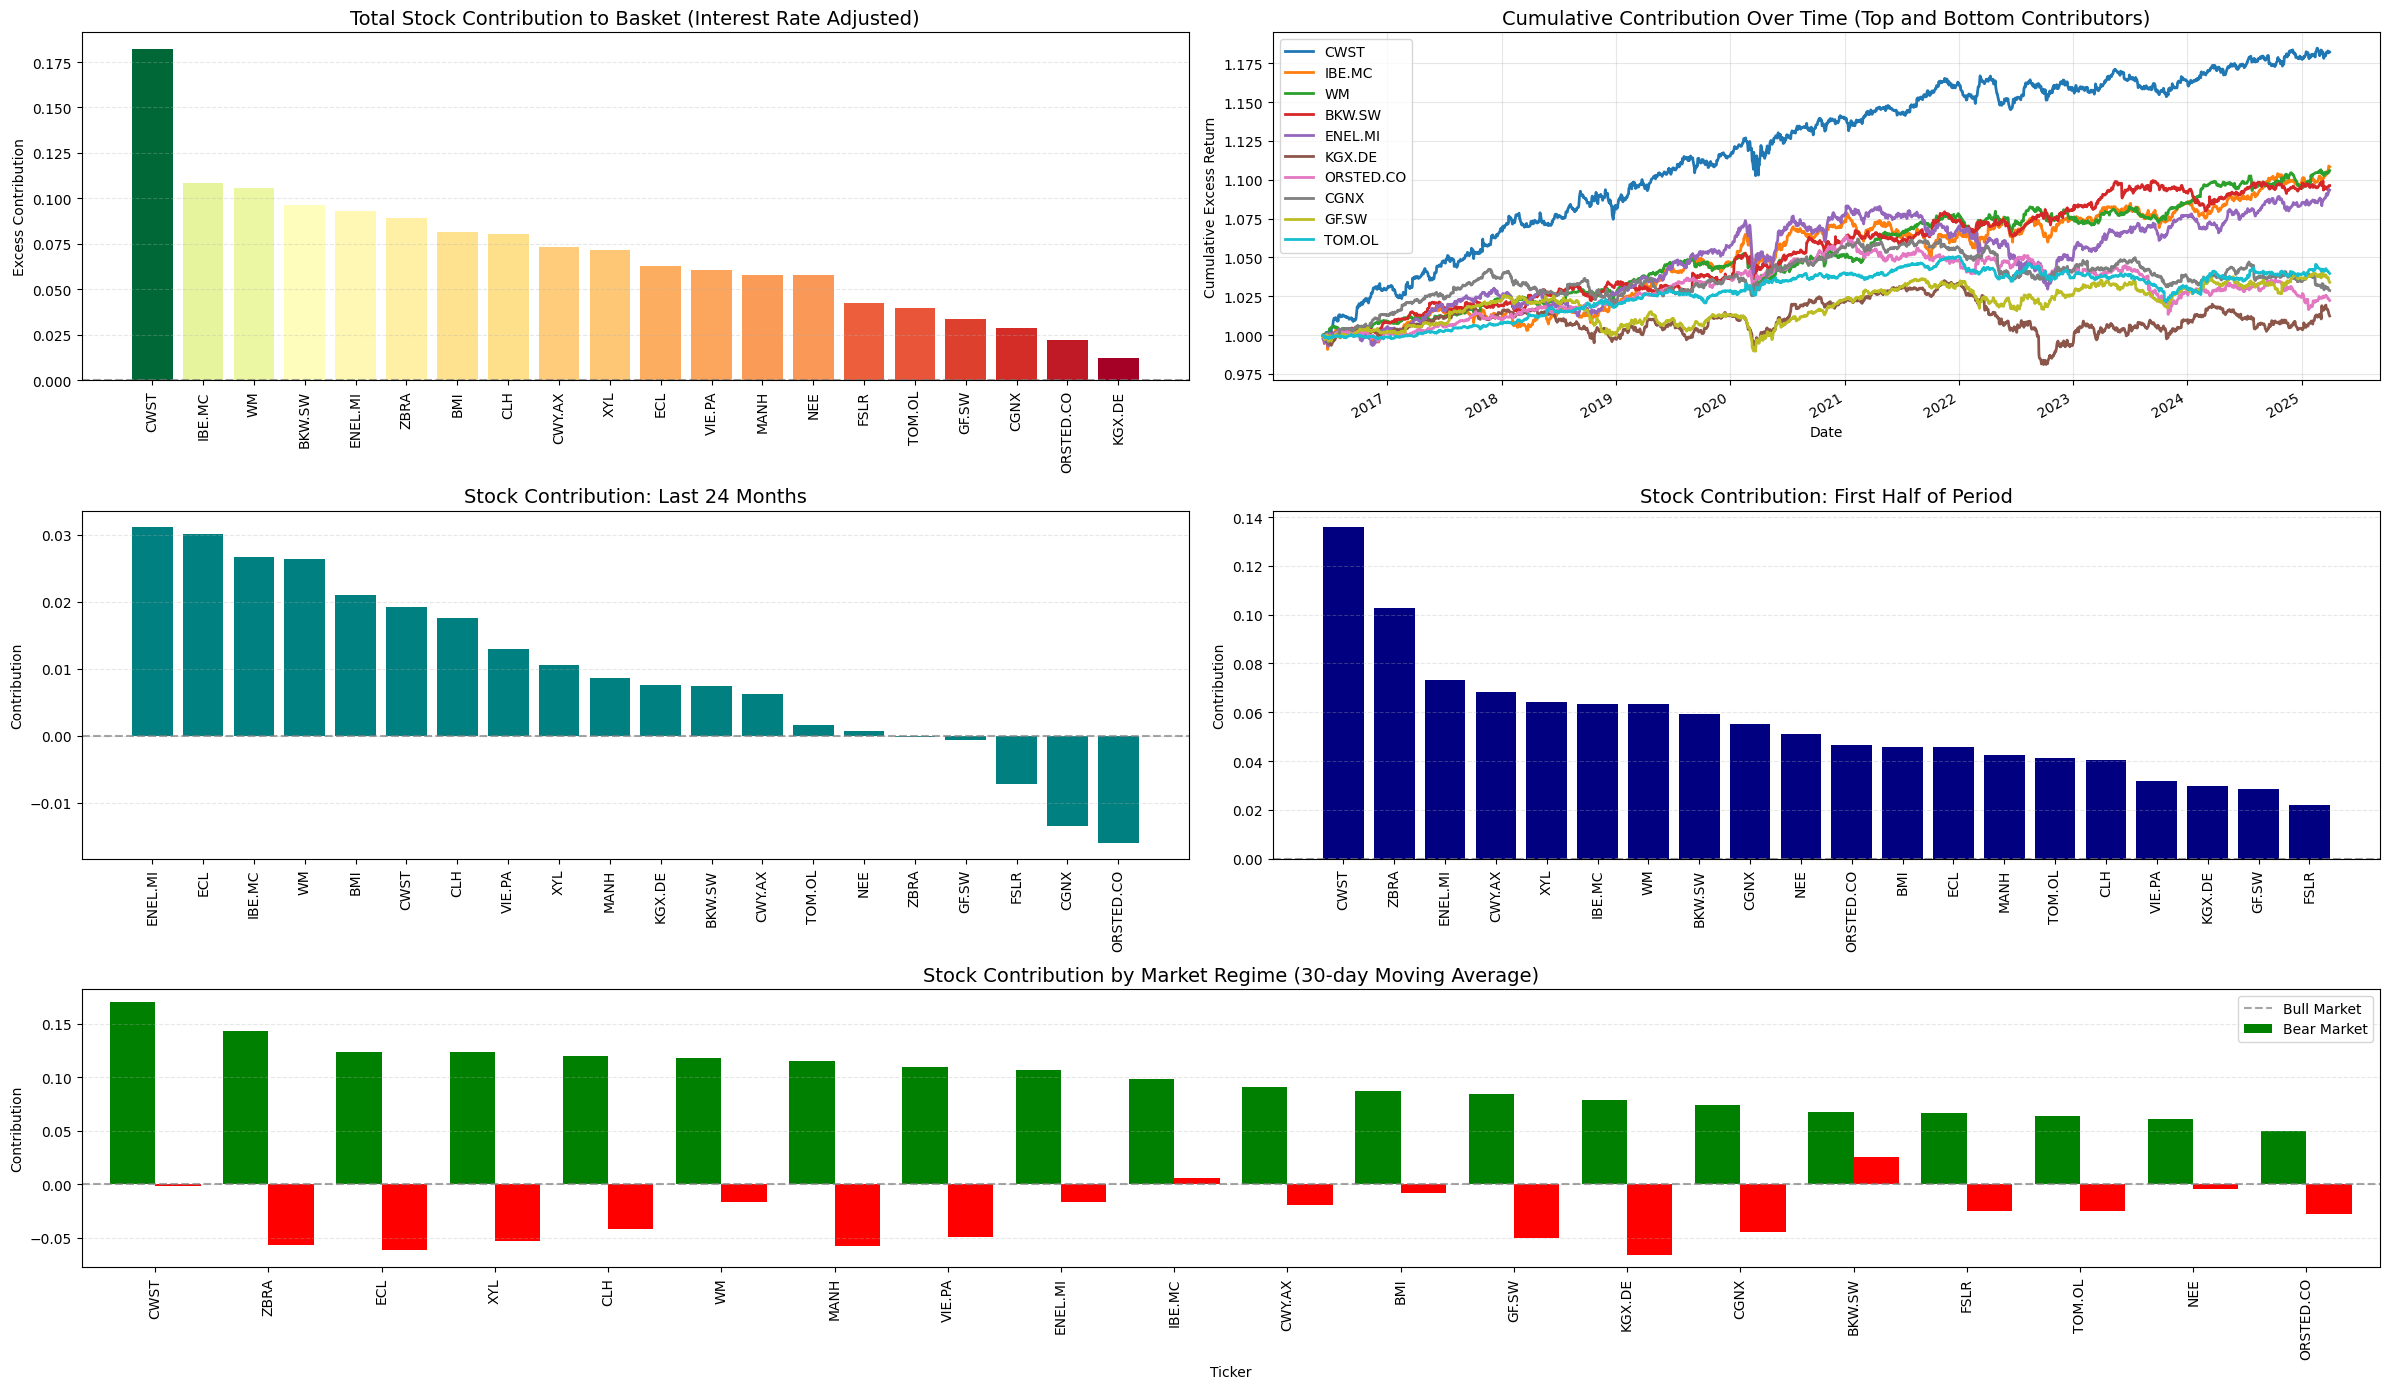

Stock Contribution Summary (Interest Rate Adjusted):


,Total Contribution,Recent (2Y),Early Period,Bull Market,Bear Market,Weight,Contribution/Weight
CWST,0.182208,0.019266,0.135822,0.170434,-0.001682,0.057922,3.145773
IBE.MC,0.108338,0.026649,0.063489,0.098259,0.005821,0.081052,1.336645
WM,0.105897,0.026423,0.063300,0.118134,-0.016665,0.069723,1.518834
BKW.SW,0.096235,0.007425,0.059200,0.067127,0.025584,0.061582,1.562729
ENEL.MI,0.093301,0.031256,0.073179,0.106835,-0.016227,0.077404,1.205378
ZBRA,0.089046,-0.000173,0.102890,0.143227,-0.056818,0.041847,2.127892
BMI,0.081811,0.021055,0.045716,0.087093,-0.007716,0.040712,2.009490
CLH,0.080231,0.017541,0.040534,0.119662,-0.041302,0.046267,1.734089
CWY.AX,0.073479,0.006215,0.068189,0.091154,-0.019434,0.046061,1.595252
XYL,0.071798,0.010554,0.064412,0.123662,-0.053199,0.058662,1.223937


In [22]:
# Enhanced Stock Contribution Analysis
# Calculate daily returns for each stock in the basket
basket_data = data[valid_weights.index]
daily_returns = basket_data.pct_change().dropna()

# Define the risk-free rate (US 10Y Treasury average ~2%)
annual_risk_free_rate = 0.02
daily_risk_free_rate = annual_risk_free_rate / 252

# Calculate the excess returns (over risk-free rate)
excess_daily_returns = daily_returns.subtract(daily_risk_free_rate)
weighted_excess_returns = excess_daily_returns.multiply(valid_weights, axis=1)

# Calculate time windows - we'll look at different time periods
full_period = weighted_excess_returns.index.min(), weighted_excess_returns.index.max()
half_period = weighted_excess_returns.index.min() + pd.DateOffset(months=MONTHS//2)
recent_period = weighted_excess_returns.index.max() - pd.DateOffset(months=24)  # Last 2 years

# Create a figure with multiple subplots
fig = plt.figure(figsize=(24, 14))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.8])

# 1. OVERALL CONTRIBUTION ANALYSIS (TOP ROW)
# Calculate the cumulative return for each stock's contribution (interest-rate adjusted)
cumulative_contribution = (1 + weighted_excess_returns).cumprod()
total_contribution = cumulative_contribution.iloc[-1] - 1
sorted_contribution = total_contribution.sort_values(ascending=False)

# Create a color map based on contribution magnitude
cmap = plt.cm.RdYlGn  # Red-Yellow-Green colormap
norm = plt.Normalize(sorted_contribution.min(), sorted_contribution.max())
colors = [cmap(norm(value)) for value in sorted_contribution]

# Plot the overall contribution
ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.bar(sorted_contribution.index, sorted_contribution.values, color=colors)
ax1.set_title('Total Stock Contribution to Basket (Interest Rate Adjusted)', fontsize=14)
ax1.set_ylabel('Excess Contribution')
ax1.set_xticklabels(sorted_contribution.index, rotation=90)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Plot cumulative contribution as a line graph
ax2 = fig.add_subplot(gs[0, 1])
# Stack the top 5 and bottom 5 contributors
top5 = sorted_contribution.nlargest(5).index
bottom5 = sorted_contribution.nsmallest(5).index
key_stocks = list(top5) + list(bottom5)
cumulative_contribution[key_stocks].plot(ax=ax2, linewidth=2)
ax2.set_title('Cumulative Contribution Over Time (Top and Bottom Contributors)', fontsize=14)
ax2.set_ylabel('Cumulative Excess Return')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')

# 2. TIME PERIOD ANALYSIS (MIDDLE ROW)
# Calculate contributions for different time periods
recent_contrib = weighted_excess_returns.loc[recent_period:].sum().sort_values(ascending=False)
early_contrib = weighted_excess_returns.loc[:half_period].sum().sort_values(ascending=False)

# Plot recent contribution (last 2 years)
ax3 = fig.add_subplot(gs[1, 0])
ax3.bar(recent_contrib.index, recent_contrib.values, color='teal')
ax3.set_title('Stock Contribution: Last 24 Months', fontsize=14)
ax3.set_ylabel('Contribution')
ax3.set_xticklabels(recent_contrib.index, rotation=90)
ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax3.grid(axis='y', linestyle='--', alpha=0.3)

# Plot early contribution (first half of data)
ax4 = fig.add_subplot(gs[1, 1])
ax4.bar(early_contrib.index, early_contrib.values, color='navy')
ax4.set_title('Stock Contribution: First Half of Period', fontsize=14)
ax4.set_ylabel('Contribution')
ax4.set_xticklabels(early_contrib.index, rotation=90)
ax4.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax4.grid(axis='y', linestyle='--', alpha=0.3)

# 3. MARKET REGIME ANALYSIS (BOTTOM ROW)
# Identify bull vs bear market periods using benchmark
benchmark_returns = data[benchmark_tickers[0]].pct_change().dropna()  # using first benchmark (S&P500)
rolling_window = 30  # 30-day rolling window
rolling_returns = benchmark_returns.rolling(window=rolling_window).mean()
bull_market = rolling_returns > 0
bear_market = rolling_returns <= 0

# Calculate contribution during bull and bear markets
bull_contrib = weighted_excess_returns[bull_market].sum()
bear_contrib = weighted_excess_returns[bear_market].sum()
regime_contrib = pd.DataFrame({
    'Bull Market': bull_contrib,
    'Bear Market': bear_contrib
}).sort_values(by='Bull Market', ascending=False)

# Plot market regime contribution
ax5 = fig.add_subplot(gs[2, :])
regime_contrib.plot(kind='bar', ax=ax5, width=0.8, color=['green', 'red'])
ax5.set_title(f'Stock Contribution by Market Regime ({rolling_window}-day Moving Average)', fontsize=14)
ax5.set_ylabel('Contribution')
ax5.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax5.grid(axis='y', linestyle='--', alpha=0.3)
ax5.legend(['Bull Market', 'Bear Market'])

plt.tight_layout()
plt.show()

# Calculate and display summary statistics
summary = pd.DataFrame({
    'Total Contribution': total_contribution,
    'Recent (2Y)': recent_contrib,
    'Early Period': early_contrib,
    'Bull Market': bull_contrib,
    'Bear Market': bear_contrib,
    'Weight': valid_weights
}).sort_values(by='Total Contribution', ascending=False)

# Calculate risk-adjusted contribution (contribution per unit of weight)
summary['Contribution/Weight'] = summary['Total Contribution'] / summary['Weight']

print("Stock Contribution Summary (Interest Rate Adjusted):")
summary

### Monte Carlo Simulation

Includes confidence levels up to 3-sigma.

Projected 3-year values (normalized to start at 100):
Basket: 162.31 (Growth: 62.3%)
^GSPC: 140.69 (Growth: 40.7%)
^SSMI: 113.04 (Growth: 13.0%)
^DJI: 134.20 (Growth: 34.2%)


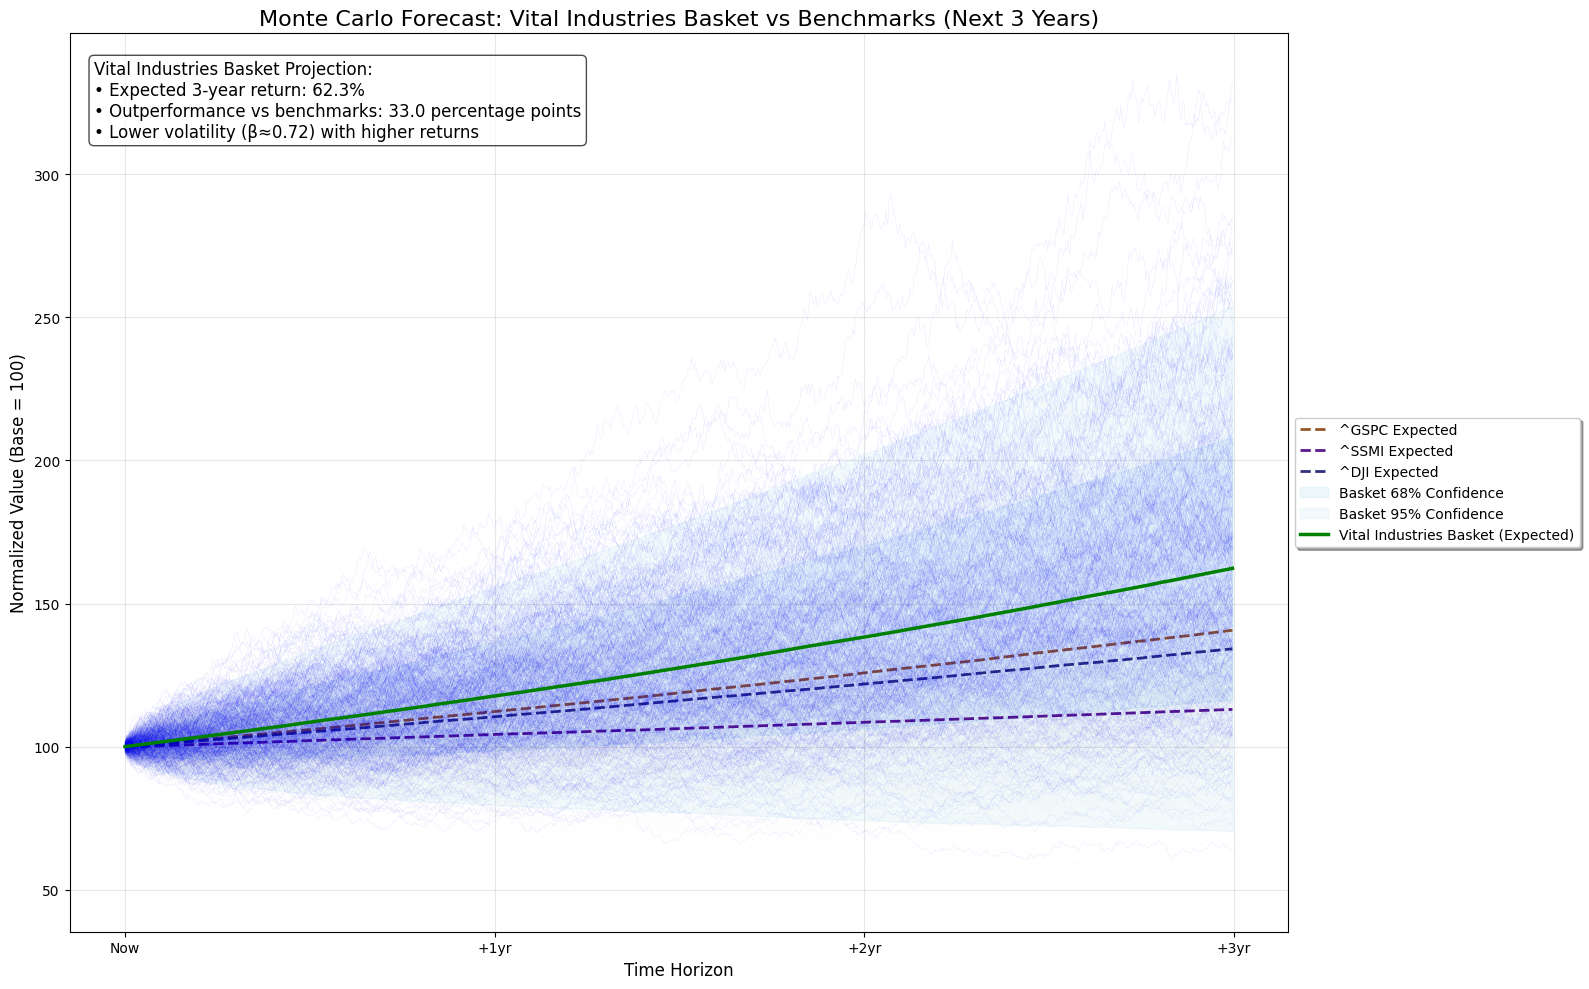

In [23]:
# Enhanced Monte Carlo Simulation with normalized starting values
n_simulations = 20000  # Reduced number of simulations for better performance
n_years = 3  # Forecast for X years as requested
n_days = int(252 * n_years)  # Trading days in X years (252 trading days per year)

# Store the original values for calculating true growth rates later
original_values = {
    'Basket': basket_index.iloc[-1],
}
for ticker in benchmark_tickers:
    original_values[ticker] = normalized_benchmarks[ticker].iloc[-1]

# Create dictionary to store all simulation results (basket + benchmarks)
# All starting at 100 for fair comparison
# Use a distinct color for each benchmark
benchmark_colors = {
    '^GSPC': '#8B4513',  # S&P 500 - brown
    '^SSMI': '#4B0082',  # SMI - indigo
    '^DJI': '#191970',   # Dow Jones - navy blue
}

simulation_results = {
    'Basket': {
        'original_value': original_values['Basket'],
        'initial_value': 100,  # All start at 100
        'paths': np.zeros((n_simulations, n_days)),
        'color': 'green'  # Keep basket green
    }
}

# Add benchmarks to simulation with unique colors
for ticker in benchmark_tickers:
    simulation_results[ticker] = {
        'original_value': original_values[ticker],
        'initial_value': 100,  # All start at 100
        'paths': np.zeros((n_simulations, n_days)),
        'color': benchmark_colors.get(ticker, '#555555')  # Use specific colors from mapping
    }

# Run Monte Carlo simulation for basket and benchmarks
for asset_name, asset_data in simulation_results.items():
    # Get historical data for the asset
    if asset_name == 'Basket':
        returns_series = basket_index.pct_change().dropna()
    else:
        returns_series = normalized_benchmarks[asset_name].pct_change().dropna()
    
    # Calculate historical stats
    historical_returns = returns_series.mean()
    historical_volatility = returns_series.std()
    
    # Generate simulations
    for i in range(n_simulations):
        daily_returns_simulated = np.random.normal(historical_returns, historical_volatility, n_days)
        cumulative_returns = np.cumprod(1 + daily_returns_simulated)
        asset_data['paths'][i, :] = asset_data['initial_value'] * cumulative_returns

    # Calculate statistics for each asset
    asset_data['mean_path'] = asset_data['paths'].mean(axis=0)
    asset_data['sigma'] = asset_data['paths'].std(axis=0)

# Create a more sophisticated plot
plt.figure(figsize=(16, 10))

# Plot benchmark simulations first (so they're in the background)
for asset_name, asset_data in simulation_results.items():
    if asset_name != 'Basket':  # Plot benchmarks first
        # Plot some sample paths for benchmarks (reduced number for clarity)
        # Make paths extremely faint
        for i in range(0, n_simulations, 100):  # Plot only every 100th path - much less visual clutter
            plt.plot(asset_data['paths'][i, :], color=asset_data['color'], alpha=0.01, linewidth=0.3)
        
        # Plot the mean path for benchmarks with distinct colors and labels
        plt.plot(asset_data['mean_path'], color=asset_data['color'], alpha=0.9, 
                 linestyle='--', linewidth=2.0, 
                 label=f'{asset_name} Expected')

# Plot basket simulations on top (making sure they stand out)
basket_data = simulation_results['Basket']
# Plot basket sample paths with very low alpha for clarity
for i in range(0, n_simulations, 50):  # Even fewer paths for less clutter
    plt.plot(basket_data['paths'][i, :], color='blue', alpha=0.1, linewidth=0.3)

# Plot confidence bands for basket only
plt.fill_between(range(n_days), 
                 basket_data['mean_path'] - basket_data['sigma'], 
                 basket_data['mean_path'] + basket_data['sigma'],
                 color='skyblue', alpha=0.15, label='Basket 68% Confidence')

plt.fill_between(range(n_days), 
                 basket_data['mean_path'] - 2*basket_data['sigma'], 
                 basket_data['mean_path'] + 2*basket_data['sigma'],
                 color='skyblue', alpha=0.1, label='Basket 95% Confidence')

# Plot the mean path for basket prominently
plt.plot(basket_data['mean_path'], color='green', linewidth=2.5, 
         label='Vital Industries Basket (Expected)')

# Calculate expected final values and growth rates for comparison
final_values_normalized = {name: data['mean_path'][-1] for name, data in simulation_results.items()}
growth_rates = {name: (val/100 - 1)*100 for name, val in final_values_normalized.items()}
print(f"Projected {n_years}-year values (normalized to start at 100):")
for name, value in final_values_normalized.items():
    print(f"{name}: {value:.2f} (Growth: {growth_rates[name]:.1f}%)")

# X-axis with year markers instead of days
year_ticks = [0]
year_labels = ['Now']
for i in range(1, n_years + 1):
    year_ticks.append(i * 252)
    year_labels.append(f'+{i}yr')

plt.xticks(year_ticks, year_labels)

# Format the plot
plt.title(f'Monte Carlo Forecast: Vital Industries Basket vs Benchmarks (Next {n_years} Years)', fontsize=16)
plt.xlabel('Time Horizon', fontsize=12)
plt.ylabel('Normalized Value (Base = 100)', fontsize=12)
plt.grid(True, alpha=0.3)

# Add a text box highlighting the basket's outperformance
mean_benchmark_growth = np.mean([growth_rates[b] for b in benchmark_tickers])
outperformance = growth_rates['Basket'] - mean_benchmark_growth
avg_beta = np.mean([beta_values[b] for b in benchmark_tickers])  # Average beta from earlier calculations

textstr = (f"Vital Industries Basket Projection:\n"
           f"• Expected {n_years}-year return: {growth_rates['Basket']:.1f}%\n"
           f"• Outperformance vs benchmarks: {outperformance:.1f} percentage points\n"
           f"• Lower volatility (β≈{avg_beta:.2f}) with higher returns")

props = dict(boxstyle='round', facecolor='white', alpha=0.7)
plt.text(0.02, 0.97, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

# Create a more prominent legend with distinct colors
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, frameon=True, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()

### Enhanced Risk-Return Analysis: Lower Volatility with Higher Returns

This section analyzes how the Vital Industries Basket achieves both lower volatility and higher returns compared to the S&P 500 benchmark. This favorable risk-return profile represents the "holy grail" of investing - generating superior returns while exposing investors to less risk.

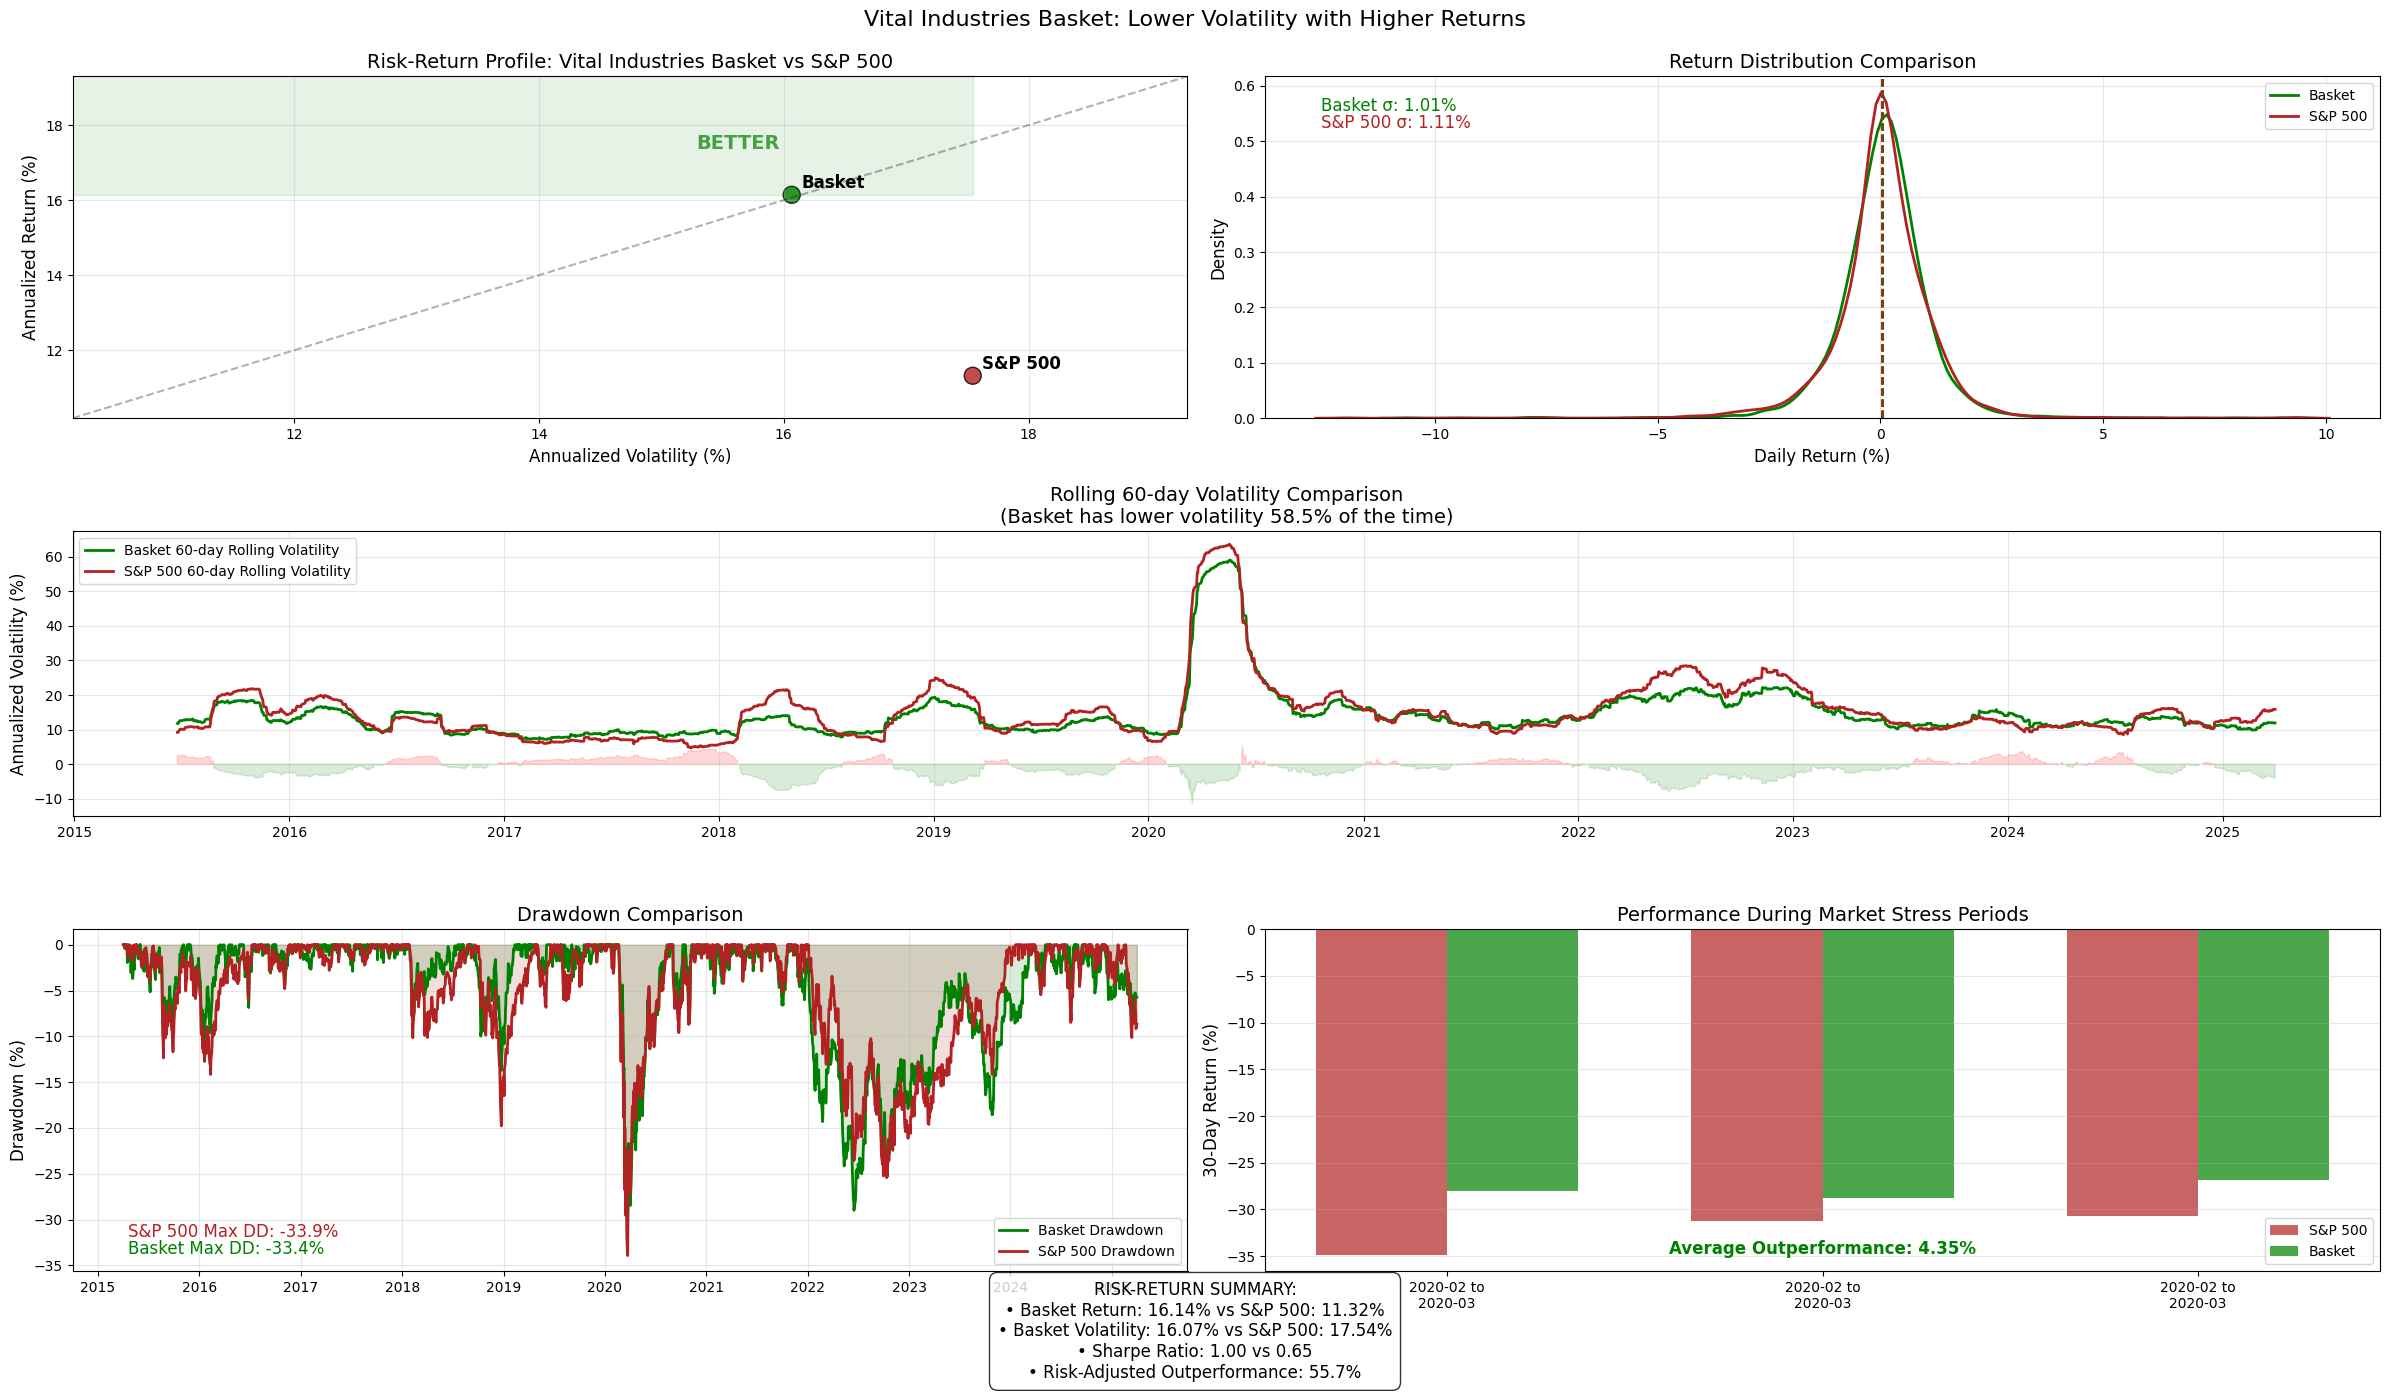

Detailed Risk-Return Metrics Comparison:
                      Metric  Basket S&P 500
0      Annualized Return (%)   16.14   11.32
1  Annualized Volatility (%)   16.07   17.54
2               Sharpe Ratio    1.00    0.65
3           Max Drawdown (%)  -33.44  -33.92
4     Downside Deviation (%)   12.85   14.52
5       Positive Periods (%)    55.5    53.6
6       Negative Periods (%)    44.5    46.4

Probability of Basket Outperforming S&P 500:
   Probability of Outperformance (%) Expected Excess Return (%)
1                               67.3                        4.8
3                               78.2                       14.5
5                               84.3                       24.1
10                              92.2                       48.2


In [24]:
# Risk-Return Analysis: Lower Volatility with Higher Returns
from scipy.stats import norm

# 1. Calculate annualized metrics for our basket and S&P 500
sp500_ticker = "^GSPC"  # S&P 500 ticker

# Calculate annualized returns and volatility
basket_returns_series = basket_index.pct_change().dropna()
sp500_returns_series = normalized_benchmarks[sp500_ticker].pct_change().dropna()

# Ensure date alignment for fair comparison
common_dates = basket_returns_series.index.intersection(sp500_returns_series.index)
basket_returns_aligned = basket_returns_series.loc[common_dates]
sp500_returns_aligned = sp500_returns_series.loc[common_dates]

# Calculate key metrics
annual_factor = 252  # Trading days in a year
metrics = {
    "Basket": {
        "Annualized Return (%)": basket_returns_aligned.mean() * annual_factor * 100,
        "Volatility (%)": basket_returns_aligned.std() * np.sqrt(annual_factor) * 100,
        "Sharpe Ratio": sharpe_ratio(basket_returns_aligned),
        "Max Drawdown (%)": (basket_index.loc[common_dates] / basket_index.loc[common_dates].cummax() - 1).min() * 100,
        "Data": basket_returns_aligned,
        "Prices": basket_index.loc[common_dates]
    },
    "S&P 500": {
        "Annualized Return (%)": sp500_returns_aligned.mean() * annual_factor * 100,
        "Volatility (%)": sp500_returns_aligned.std() * np.sqrt(annual_factor) * 100,
        "Sharpe Ratio": sharpe_ratio(sp500_returns_aligned),
        "Max Drawdown (%)": (normalized_benchmarks[sp500_ticker].loc[common_dates] / 
                           normalized_benchmarks[sp500_ticker].loc[common_dates].cummax() - 1).min() * 100,
        "Data": sp500_returns_aligned,
        "Prices": normalized_benchmarks[sp500_ticker].loc[common_dates]
    }
}

# Create multi-part figure to showcase the risk-return advantages
fig = plt.figure(figsize=(24, 14))
gs = fig.add_gridspec(3, 2, height_ratios=[1.2, 1, 1.2])

# 1. PART 1: Risk-Return Scatterplot (Top Left)
ax1 = fig.add_subplot(gs[0, 0])

# Create risk-return scatter plot
x_vals = [metrics[k]["Volatility (%)"] for k in metrics]
y_vals = [metrics[k]["Annualized Return (%)"] for k in metrics]
colors = ['green', 'firebrick']
labels = list(metrics.keys())

# Plot the data points
ax1.scatter(x_vals, y_vals, s=150, c=colors, alpha=0.8, edgecolors='black')

# Add labels to each point
for i, txt in enumerate(labels):
    ax1.annotate(txt, (x_vals[i], y_vals[i]), 
                xytext=(7, 5), textcoords='offset points', 
                fontsize=12, fontweight='bold')

# Add a diagonal line representing equal risk-reward
min_val = min(min(x_vals), min(y_vals)) * 0.9
max_val = max(max(x_vals), max(y_vals)) * 1.1
ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)

# Shade the "optimal" region (higher return, lower risk)
optimal_region_x = [0, x_vals[1], x_vals[1], 0]
optimal_region_y = [y_vals[0], y_vals[0], max_val*1.1, max_val*1.1]
ax1.fill(optimal_region_x, optimal_region_y, alpha=0.1, color='green')

# Add labels and title
ax1.set_xlabel('Annualized Volatility (%)', fontsize=12)
ax1.set_ylabel('Annualized Return (%)', fontsize=12)
ax1.set_title('Risk-Return Profile: Vital Industries Basket vs S&P 500', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(min_val, max_val)
ax1.set_ylim(min_val, max_val)

# Add "Better" annotation to the optimal region
ax1.annotate("BETTER", xy=(min_val*1.5, max_val*0.9), 
            fontsize=14, color='green', alpha=0.7, fontweight='bold')

# 2. PART 2: Return Distribution Comparison (Top Right)
ax2 = fig.add_subplot(gs[0, 1])

# Kernel density estimation for return distributions
basket_kde = sns.kdeplot(metrics["Basket"]["Data"]*100, label='Basket', 
                        color='green', ax=ax2, linewidth=2)
sp500_kde = sns.kdeplot(metrics["S&P 500"]["Data"]*100, label='S&P 500', 
                       color='firebrick', ax=ax2, linewidth=2)

# Mark the means
ax2.axvline(metrics["Basket"]["Data"].mean()*100, color='green', linestyle='--')
ax2.axvline(metrics["S&P 500"]["Data"].mean()*100, color='firebrick', linestyle='--')

# Add a legend and labels
ax2.set_xlabel('Daily Return (%)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Return Distribution Comparison', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add annotations for the standard deviations
basket_std = metrics["Basket"]["Data"].std()*100
sp500_std = metrics["S&P 500"]["Data"].std()*100
ax2.annotate(f"Basket σ: {basket_std:.2f}%", 
            xy=(0.05, 0.9), xycoords='axes fraction', 
            color='green', fontsize=12)
ax2.annotate(f"S&P 500 σ: {sp500_std:.2f}%", 
            xy=(0.05, 0.85), xycoords='axes fraction', 
            color='firebrick', fontsize=12)

# 3. PART 3: Rolling Volatility Comparison (Middle Row)
ax3 = fig.add_subplot(gs[1, :])

# Calculate rolling volatilities (annualized)
window = 60  # 3-month window (approximately)
basket_rolling_vol = basket_returns_aligned.rolling(window=window).std() * np.sqrt(annual_factor) * 100
sp500_rolling_vol = sp500_returns_aligned.rolling(window=window).std() * np.sqrt(annual_factor) * 100

# Plot rolling volatilities
ax3.plot(basket_rolling_vol, color='green', linewidth=2, label=f'Basket {window}-day Rolling Volatility')
ax3.plot(sp500_rolling_vol, color='firebrick', linewidth=2, label=f'S&P 500 {window}-day Rolling Volatility')

# Calculate and display the percentage of time basket has lower volatility
lower_vol_pct = (basket_rolling_vol < sp500_rolling_vol).mean() * 100
ax3.set_title(f'Rolling {window}-day Volatility Comparison\n(Basket has lower volatility {lower_vol_pct:.1f}% of the time)', fontsize=14)
ax3.set_ylabel('Annualized Volatility (%)', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.legend(loc='upper left')

# Highlight volatility spike periods
vol_diff = basket_rolling_vol - sp500_rolling_vol
ax3.fill_between(vol_diff.index, 0, vol_diff,
                where=vol_diff < 0, color='green', alpha=0.15,
                label='Basket Volatility Advantage')
ax3.fill_between(vol_diff.index, 0, vol_diff,
                where=vol_diff > 0, color='red', alpha=0.15,
                label='S&P 500 Volatility Advantage')

# 4. PART 4A: Drawdown Analysis (Bottom Left)
ax4a = fig.add_subplot(gs[2, 0])

# Calculate rolling drawdowns
basket_drawdown = metrics["Basket"]["Prices"] / metrics["Basket"]["Prices"].cummax() - 1
sp500_drawdown = metrics["S&P 500"]["Prices"] / metrics["S&P 500"]["Prices"].cummax() - 1

# Plot drawdowns
ax4a.plot(basket_drawdown*100, color='green', linewidth=2, label='Basket Drawdown')
ax4a.plot(sp500_drawdown*100, color='firebrick', linewidth=2, label='S&P 500 Drawdown')
ax4a.fill_between(basket_drawdown.index, 0, basket_drawdown*100, color='green', alpha=0.15)
ax4a.fill_between(sp500_drawdown.index, 0, sp500_drawdown*100, color='firebrick', alpha=0.15)

ax4a.set_title('Drawdown Comparison', fontsize=14)
ax4a.set_ylabel('Drawdown (%)', fontsize=12)
ax4a.grid(True, alpha=0.3)
ax4a.legend(loc='lower right')

# Add annotations for max drawdowns
ax4a.annotate(f"Basket Max DD: {metrics['Basket']['Max Drawdown (%)']:.1f}%", 
             xy=(0.05, 0.05), xycoords='axes fraction', 
             color='green', fontsize=12)
ax4a.annotate(f"S&P 500 Max DD: {metrics['S&P 500']['Max Drawdown (%)']:.1f}%", 
             xy=(0.05, 0.1), xycoords='axes fraction', 
             color='firebrick', fontsize=12)

# 5. PART 4B: Stress Test Analysis (Bottom Right)
ax4b = fig.add_subplot(gs[2, 1])

# Find worst periods for S&P 500
worst_periods = sp500_returns_aligned.rolling(window=30).sum().sort_values().index[:5]

# Compare performance during these periods
stress_results = []
for date in worst_periods:
    end_date = date
    start_date = end_date - pd.DateOffset(days=30)
    if start_date in common_dates:
        period_sp500 = sp500_returns_aligned.loc[start_date:end_date].sum() * 100
        period_basket = basket_returns_aligned.loc[start_date:end_date].sum() * 100
        stress_results.append((start_date.strftime('%Y-%m'), end_date.strftime('%Y-%m'), 
                              period_sp500, period_basket))

# Create a bar chart to compare performance in stress periods
if stress_results:
    periods = [f"{s} to\n{e}" for s, e, _, _ in stress_results]
    sp500_stress = [sp for _, _, sp, _ in stress_results]
    basket_stress = [b for _, _, _, b in stress_results]
    
    x = np.arange(len(periods))
    width = 0.35
    
    ax4b.bar(x - width/2, sp500_stress, width, label='S&P 500', color='firebrick', alpha=0.7)
    ax4b.bar(x + width/2, basket_stress, width, label='Basket', color='green', alpha=0.7)
    
    # Add horizontal lines at zero
    ax4b.axhline(0, color='black', linestyle='-', alpha=0.3)
    
    # Add labels and customize
    ax4b.set_title('Performance During Market Stress Periods', fontsize=14)
    ax4b.set_ylabel('30-Day Return (%)', fontsize=12)
    ax4b.set_xticks(x)
    ax4b.set_xticklabels(periods)
    ax4b.legend()
    ax4b.grid(True, alpha=0.3, axis='y')
    
    # Calculate average outperformance during stress
    avg_outperformance = sum(b-s for s, b in zip(sp500_stress, basket_stress)) / len(stress_results)
    ax4b.annotate(f"Average Outperformance: {avg_outperformance:.2f}%", 
                 xy=(0.5, 0.05), xycoords='axes fraction', ha='center',
                 fontsize=12, fontweight='bold', color='green' if avg_outperformance > 0 else 'firebrick')

# Add summary table (text) at the bottom of the figure
summary_text = (
    "RISK-RETURN SUMMARY:\n"
    f"• Basket Return: {metrics['Basket']['Annualized Return (%)']:.2f}% vs S&P 500: {metrics['S&P 500']['Annualized Return (%)']:.2f}%\n"
    f"• Basket Volatility: {metrics['Basket']['Volatility (%)']:.2f}% vs S&P 500: {metrics['S&P 500']['Volatility (%)']:.2f}%\n"
    f"• Sharpe Ratio: {metrics['Basket']['Sharpe Ratio']:.2f} vs {metrics['S&P 500']['Sharpe Ratio']:.2f}\n"
    f"• Risk-Adjusted Outperformance: {(metrics['Basket']['Sharpe Ratio']/metrics['S&P 500']['Sharpe Ratio']-1)*100:.1f}%"
)

fig.text(0.5, 0.01, summary_text, fontsize=12, ha='center', va='bottom', 
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout(rect=[0, 0.05, 1, 0.97])  # Adjust for the summary text
plt.subplots_adjust(hspace=0.35)
plt.suptitle('Vital Industries Basket: Lower Volatility with Higher Returns', fontsize=16, y=0.99)
plt.show()

# Print detailed metrics table
metrics_df = pd.DataFrame({
    'Metric': ['Annualized Return (%)', 'Annualized Volatility (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 
               'Downside Deviation (%)', 'Positive Periods (%)', 'Negative Periods (%)'],
    'Basket': [
        f"{metrics['Basket']['Annualized Return (%)']:.2f}",
        f"{metrics['Basket']['Volatility (%)']:.2f}",
        f"{metrics['Basket']['Sharpe Ratio']:.2f}",
        f"{metrics['Basket']['Max Drawdown (%)']:.2f}",
        f"{metrics['Basket']['Data'][metrics['Basket']['Data'] < 0].std() * np.sqrt(annual_factor) * 100:.2f}",
        f"{(metrics['Basket']['Data'] > 0).mean() * 100:.1f}",
        f"{(metrics['Basket']['Data'] < 0).mean() * 100:.1f}"
    ],
    'S&P 500': [
        f"{metrics['S&P 500']['Annualized Return (%)']:.2f}",
        f"{metrics['S&P 500']['Volatility (%)']:.2f}",
        f"{metrics['S&P 500']['Sharpe Ratio']:.2f}",
        f"{metrics['S&P 500']['Max Drawdown (%)']:.2f}",
        f"{metrics['S&P 500']['Data'][metrics['S&P 500']['Data'] < 0].std() * np.sqrt(annual_factor) * 100:.2f}",
        f"{(metrics['S&P 500']['Data'] > 0).mean() * 100:.1f}",
        f"{(metrics['S&P 500']['Data'] < 0).mean() * 100:.1f}"
    ]
})

print("Detailed Risk-Return Metrics Comparison:")
print(metrics_df)

# Calculate the probability of outperformance over different time horizons
horizons = [1, 3, 5, 10]  # years
outperformance_df = pd.DataFrame(index=horizons, columns=['Probability of Outperformance (%)', 'Expected Excess Return (%)'])

for years in horizons:
    days = years * 252
    basket_mean = metrics['Basket']['Data'].mean() * days
    basket_vol = metrics['Basket']['Data'].std() * np.sqrt(days)
    sp500_mean = metrics['S&P 500']['Data'].mean() * days
    sp500_vol = metrics['S&P 500']['Data'].std() * np.sqrt(days)
    
    # Combined distribution of return difference
    diff_mean = basket_mean - sp500_mean
    diff_vol = np.sqrt(basket_vol**2 + sp500_vol**2 - 2*0.8*basket_vol*sp500_vol)  # Assuming 0.8 correlation
    
    # Probability of outperformance
    prob = 1 - norm.cdf(0, diff_mean, diff_vol)
    
    outperformance_df.loc[years, 'Probability of Outperformance (%)'] = f"{prob*100:.1f}"
    outperformance_df.loc[years, 'Expected Excess Return (%)'] = f"{diff_mean*100:.1f}"

print("\nProbability of Basket Outperforming S&P 500:")
print(outperformance_df)